In [239]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
import os

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict

import xgboost as xgb




In [240]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def pcaFcn(input_data, output_data, pca_count, scale_yn):
    pca = PCA(n_components=pca_count)
    input_data_pca = pca.fit_transform(input_data)
    X_train, X_test, y_train, y_test = train_test_split(input_data_pca, output_data, shuffle=True, test_size=0.15)
    if(scale_yn == "Y"):
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)
        
    y_train = np.array(y_train).astype(float) # 정수로 변환
    y_test = np.array(y_test).astype(float)

        
    return (X_train, X_test, y_train, y_test)
    
"""
:param x_data       : 입력 데이터
:param y_data       : 출력 데이터
:param test_data    : 테스트 데이터
:param hidden_layer : 층
:return: RMSE 값
"""
def neuralNetwork(x_data, y_data, test_data, y_test, hidden_layer):
    # NN
    mlp = MLPClassifier(solver='lbfgs', random_state=2, hidden_layer_sizes=[hidden_layer]).fit(x_data, y_data)
    pdct = mlp.predict(test_data)
    score = mlp.score(test_data, y_test)
    return (pdct, score)

In [241]:
# 현재 폴더에서 8direction 폴더의 경로 가져오기
eight_direction_path = os.path.join(os.getcwd(), '8direction')

# 8direction 폴더 안에 있는 엑셀 파일 목록 가져오기
excel_files = [file for file in os.listdir(eight_direction_path) if file.endswith('.xlsx') or file.endswith('.xls')]

# 각 엑셀 파일을 불러와서 데이터프레임으로 저장
dfs = []
for idx, file in enumerate(excel_files):
    file_name = file.replace('.xlsx', '')
    file_path = os.path.join(eight_direction_path, file)
    df = pd.read_excel(file_path)
    df = df.set_index('date')  # date 컬럼을 인덱스로 설정
    # tmin, tmax, wspd, pres를 제외한 모든 컬럼 삭제
    df = df[[col for col in df.columns if col in ['tmin', 'tmax', 'wspd', 'pres']]]
    
    df.columns = [f"{file_name}_{col}" for col in df.columns]  # 각 열에 파일 이름을 붙임
    dfs.append(df)

# 모든 데이터프레임을 날짜 기준으로 옆으로 연결
combined_df = pd.concat(dfs, axis=1)
# Features와 Target으로 데이터 분할
X = combined_df.drop(columns=['nebraska_tmin', 'nebraska_tmax', 'nebraska_wspd', 'nebraska_pres'])
y = combined_df['nebraska_tmin']
# 하루 shift
combined_df = pd.concat([X.iloc[:-1, :], y.iloc[:-1]], axis=1)


In [242]:
# 결측값 제거
combined_df = combined_df.dropna(axis=0)

X = combined_df.drop(columns=['nebraska_tmin'])
y = combined_df['nebraska_tmin']

# Training set과 Test set으로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# minMax sclae
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


0.9568321112836106
2.324403598870256


c:\Users\swjin\Documents\study\code\weather_forecasting\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


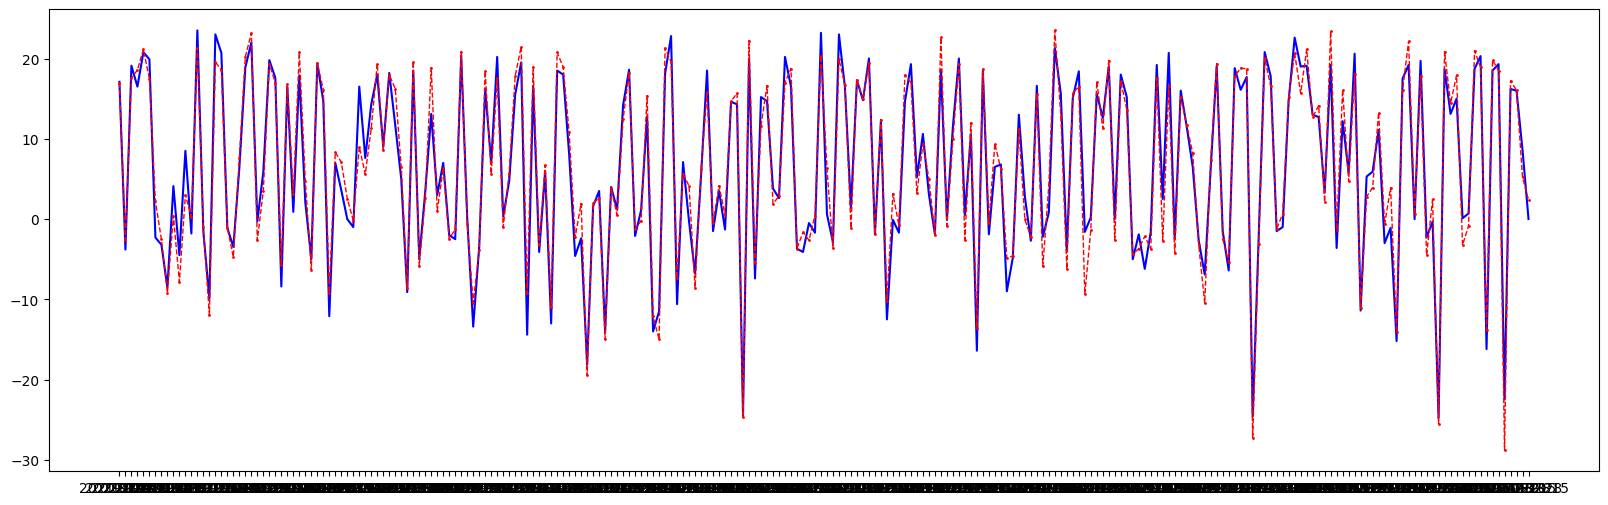

In [243]:
# PCA 
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# NN 예측
mlp = MLPRegressor(solver='lbfgs', random_state=2, hidden_layer_sizes=[9]).fit(X_train_pca, y_train)
pdct = mlp.predict(X_test_pca)
score = mlp.score(X_test_pca, y_test)
print(score)
print(rmse(pdct, y_test))

plt.figure(figsize=(20,6))
plt.plot(y_test, c='b')
plt.plot(pdct, c='r', linestyle = '--', marker = 'o', markersize = 1, linewidth=1)

0.9588183739334756
2.270298072349691


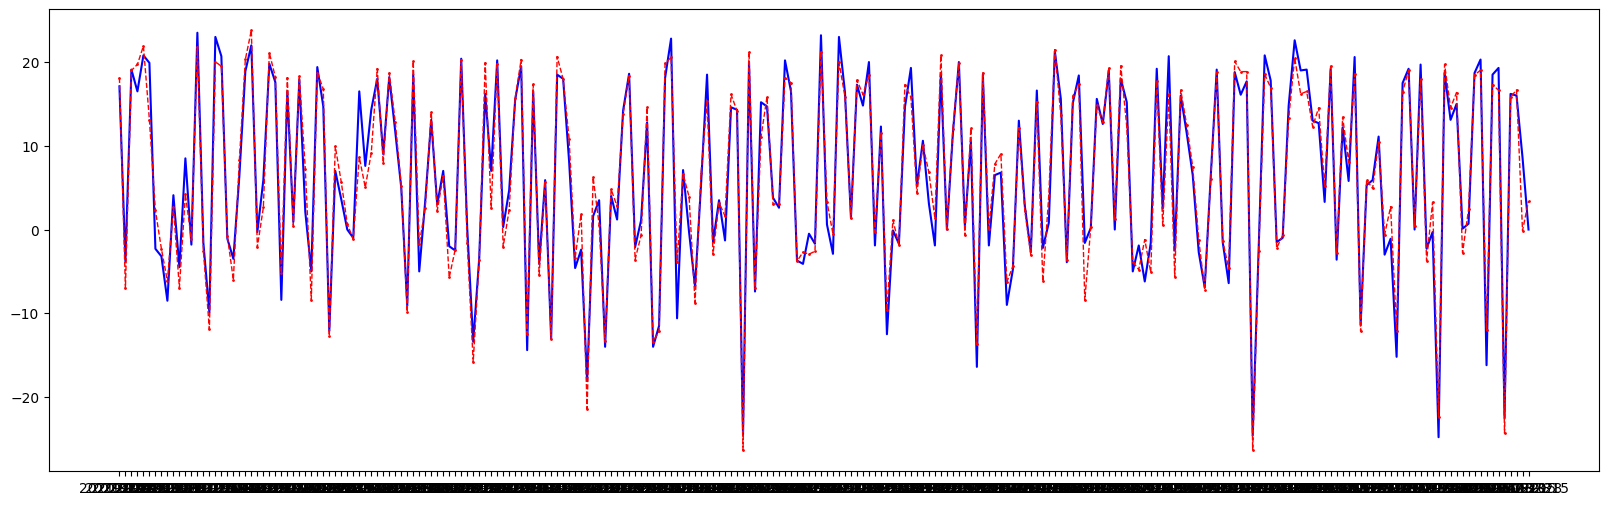

In [244]:
# Define PLS object
pls = PLSRegression(n_components=5)
 
# Fit
pls.fit(X_train_pca, y_train)
 
# Cross-validation
y_prd = cross_val_predict(pls, X_test_pca, y_test, cv=10)
 
# Calculate scores
score = r2_score(y_test, y_prd)
print(score)
print(rmse(y_prd, y_test))

plt.figure(figsize=(20,6))
plt.plot(y_test, c='b')
plt.plot(y_prd, c='r', linestyle = '--', marker = 'o', markersize = 1, linewidth=1)

2.85184681013218
2.85184681013218


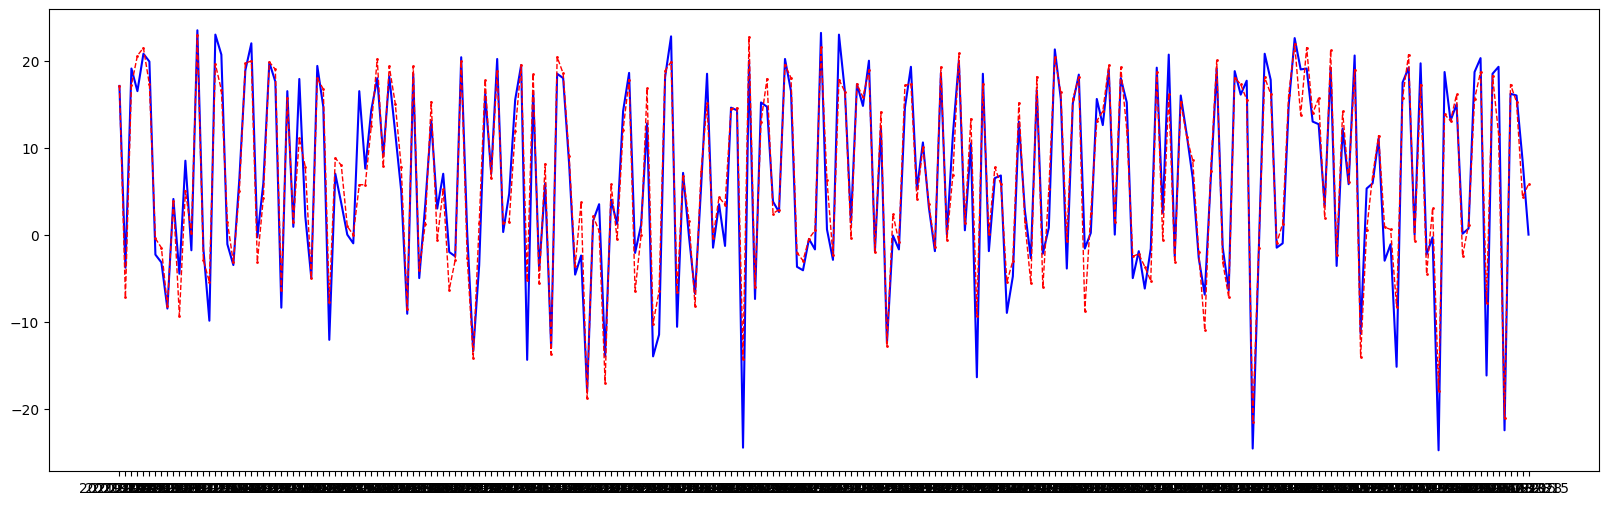

In [245]:
# XGBoost 회귀 모델 정의
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)

# 모델 훈련
xgb_reg.fit(X_train_pca, y_train)

# 테스트 데이터로 예측 수행
y_prd = xgb_reg.predict(X_test_pca)

print(rmse(y_prd, y_test))
plt.figure(figsize=(20,6))
plt.plot(y_test, c='b')
plt.plot(y_prd, c='r', linestyle = '--', marker = 'o', markersize = 1, linewidth=1)